# Detección de anomalías en un marco de auditoría continua

## 6.3. Modelos no supervisados

### 6.3.1. Split del dataset

Split del dataset para reservar un conjunto de datos para validación posterior al entrenamiento y desarrollo de los modelos.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import time
import joblib
import math
import matplotlib.pyplot as plt

In [2]:
# Filtro de warnings.
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carga del dataset.
df = pd.read_csv('df_preprocessed.csv')
df.head()

,day,hour,amount,idOrig,oldbalanceOrig,newbalanceOrig,idDest,oldbalanceDest,newbalanceDest,Cash_in,Cash_out,Debit,Payment,Transfer,isFraud,isFlaggedFraud
0,1,1,9839.64,0,170136.0,160296.36,6353307,0.0,0.0,0,0,0,1,0,0,0
1,1,1,1864.28,1,21249.0,19384.72,6353308,0.0,0.0,0,0,0,1,0,0,0
2,1,1,181.00,2,181.0,0.00,6353309,0.0,0.0,0,0,0,0,1,1,0
3,1,1,181.00,3,181.0,0.00,6353310,21182.0,0.0,0,1,0,0,0,1,0
4,1,1,11668.14,4,41554.0,29885.86,6353311,0.0,0.0,0,0,0,1,0,0,0


In [4]:
# Split del dataset para reservar un conjunto de validación.
from sklearn.model_selection import train_test_split
df_training, df_validation = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = np.array(df['isFraud']))

In [5]:
# Control de frecuencias de clases.
print('Proporcion de clases para dataset de training: %.4f' % (df_training['isFraud'].value_counts()[1] / df_training['isFraud'].value_counts()[0]))
print('Proporcion de clases para dataset de validación: %.4f' % (df_validation['isFraud'].value_counts()[1] / df_validation['isFraud'].value_counts()[0]))

Proporcion de clases para dataset de training: 0.0013
Proporcion de clases para dataset de validación: 0.0013


In [6]:
# Separación del dataset en variable a predecir y predictores
X = df_training.drop(labels = ['isFraud', 'isFlaggedFraud'], axis = 1, inplace = False)
y = df_training['isFraud']

### 6.3.2. Clustering - K-Means

https://scikit-learn.org/stable/modules/clustering.html#clustering

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans

Clase mayoritaria

In [ ]:
X_backup = X.copy()
y_backup = y.copy()

In [ ]:
X = X_backup.copy()
y = y_backup.copy()

In [ ]:
import itertools

# Espacio de soluciones.
items =  ['day', 'hour', 'idOrig', 'idDest']
combinations = []
for item in range(0, len(items) + 1):
    for subset in itertools.combinations(items, item):
        combinations.append(list(subset))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss

# Split del dataset en train, test.
train, test = train_test_split(df_training, train_size = 0.8, random_state = 42, shuffle = True, stratify = y)
X_train = train.drop(labels = ['isFraud', 'isFlaggedFraud'], axis = 1, inplace = False)
X_test = test.drop(labels = ['isFraud', 'isFlaggedFraud'], axis = 1, inplace = False)
y_train = train['isFraud']
y_test = test['isFraud']

# Definición del espacio / dominio de parámetros.
search_space = {'scaler': hp.choice('scaler', [None, RobustScaler(), StandardScaler(), MinMaxScaler(), MaxAbsScaler()]),
                'filter': hp.choice('filter', combinations),
                'params': {'n_clusters' : 2,
                           'max_iter': hp.randint('b', 20, 500),
                           'n_init': hp.randint('n_init', 1, 50),
                           'tol': 0.0001,
                           'algorithm': hp.choice('algorithm', ['auto', 'full', 'elkan'])
                          }
               }

# Definición de la función objetivo.
def objective_func(search_space):
    
    global counter, scorings
    start_time = time.time()
    counter += 1
       
    if search_space['scaler'] == None:
        None
    else:
        scaler = search_space['scaler']
        scaler.fit_transform(X_train)
        scaler.fit_transform(X_test)
    
    kmeans = KMeans(**search_space['params'], random_state = 42)
    kmeans = kmeans.fit(X = X_train)
    y_pred = kmeans.predict(X_test)
    
    if sum(y_pred) <= (len(y_pred) - sum(y_pred)):
        None
    else:
        for i, j in enumerate(y_pred):
            if j == 0:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
      
    loss = 1 - f1_score(y_test, y_pred)

    scorings.append({'trial': counter,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': recall_score(y_test, y_pred),
                                   'Precision': precision_score(y_test, y_pred),
                                   'AUC': roc_auc_score(y_test, y_pred),
                                   'Accuracy': accuracy_score(y_test, y_pred),
                                   'F1-Score': f1_score(y_test, y_pred)}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (counter, loss, elapsed_time))
    
    return loss

# Ejecución del optimizador.
counter = -1
scorings = []
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate = rstate)

### 6.3.3. Detección de anomalías utilizando la Ley de Benford

https://towardsdatascience.com/frawd-detection-using-benfords-law-python-code-9db8db474cf8

https://github.com/eleprocha/Benford-s-Law_python_code/blob/master/code

In [7]:
# Configuración de número de decimales.
pd.options.display.float_format = '{:.2f}'.format

# Analisis exploratorio de datos.      
with pd.option_context('display.max_rows', None, 'display.max_columns', 10, 'display.width', 1000):
    print(df.describe().transpose())
print()
print(df.info())
print()
print(df.isnull().sum())

                    count       mean        std    min        25%        50%        75%          max
day            6362620.00      10.49       5.92   1.00       7.00      10.00      14.00        31.00
hour           6362620.00       8.37       4.56   1.00       6.00       8.00      11.00        24.00
amount         6362620.00  179861.90  603858.23   0.00   13389.57   74871.94  208721.48  92445516.64
idOrig         6362620.00 3175068.41 1834059.22   0.00 1586504.75 3174301.50 4763206.25   6353306.00
oldbalanceOrig 6362620.00  833883.10 2888242.67   0.00       0.00   14208.00  107315.18  59585040.37
newbalanceOrig 6362620.00  855113.67 2924048.50   0.00       0.00       0.00  144258.41  49585040.37
idDest         6362620.00 7275614.81  795239.09 571.00 6611227.00 7083926.00 7842574.25   9073899.00
oldbalanceDest 6362620.00 1100701.67 3399180.11   0.00       0.00  132705.66  943036.71 356015889.35
newbalanceDest 6362620.00 1224996.40 3674128.94   0.00       0.00  214661.44 1111909.25 356

In [10]:
# Función para el cálculo de frecuencias relativas.
def count_first_digit(data_str):
    mask=df[data_str]>1.
    data=list(df[mask][data_str])
    for i in range(len(data)):
        while data[i]>10:
            data[i]=data[i]/10
    first_digits=[int(x) for x in sorted(data)]
    unique=(set(first_digits))#a list with unique values of     first_digit list
    data_count=[]
    for i in unique:
        count=first_digits.count(i)
        data_count.append(count)
    total_count=sum(data_count)
    data_percentage=[(i/total_count)*100 for i in data_count]
    return  total_count,data_count, data_percentage

total_count, data_count, data_percentage = count_first_digit('amount')

In [25]:
BENFORD = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]

In [26]:
def get_expected_counts(total_count):
    # Benford's Law percentages for leading digits 1-9
    BENFORD = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]
    """Return list of expected Benford's Law counts for total sample count."""
    return [round(p * total_count / 100) for p in BENFORD]
expected_counts=get_expected_counts(total_count)

In [13]:
data_count

[2134173,
 1302139,
 798406,
 526686,
 395748,
 334283,
 305911,
 287550,
 274247,
 3344]

In [12]:
expected_counts

[1915109, 1119798, 795311, 617161, 502636, 426287, 369024, 324487, 292674]

In [16]:
def chi_square_test(data_count,expected_counts):
    """Return boolean on chi-square test (8 degrees of freedom & P-val=0.05)."""
    chi_square_stat = 0  # chi square test statistic
    for data, expected in zip(data_count,expected_counts):

        chi_square = math.pow(data - expected, 2)

        chi_square_stat += chi_square / expected

    print("\nChi-squared Test Statistic = {:.3f}".format(chi_square_stat))
    print("Critical value at a P-value of 0.05 is 15.51.")    
    return chi_square_stat < 15.51

chi_square_test(data_count,expected_counts)


Chi-squared Test Statistic = 126770.925
Critical value at a P-value of 0.05 is 15.51.


False

In [23]:
#1st_bar_chart
def bar_chart(data_pct):
    """Make bar chart of observed vs expected 1st digit frequency in percent."""
    fig, ax = plt.subplots()
    index = [i + 1 for i in range(len(data_pct))]  # 1st digits for x-axis
    # text for labels, title and ticks

    fig.canvas.set_window_title('Percentage First Digits')

    ax.set_title('Data vs. Benford Values', fontsize=15)

    ax.set_ylabel('Frequency (%)', fontsize=16)

    ax.set_xticks(index)

    ax.set_xticklabels(index, fontsize=14)



    # build bars    

    rects = ax.bar(index, data_pct, width=0.95, color='black', label='Data')



    # attach a text label above each bar displaying its height

    for rect in rects:

        height = rect.get_height()

        ax.text(rect.get_x() + rect.get_width()/2, height,

                '{:0.1f}'.format(height), ha='center', va='bottom', 

                fontsize=13)



    # plot Benford values as red dots

    ax.scatter(index, BENFORD, s=150, c='red', zorder=2, label='Benford')



    # Hide the right and top spines & add legend

    ax.spines['right'].set_visible(False)

    ax.spines['top'].set_visible(False)

    ax.legend(prop={'size':15}, frameon=False)

    

    plt.show()

In [21]:
index = [i + 1 for i in range(len(data_count))]

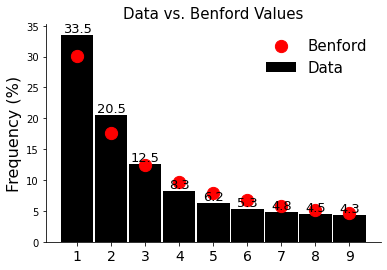

In [37]:
import matplotlib.pyplot as plt
bar_chart(data_percentage[0:9])

### 6.3.4. Detección de anomalías utilizando métodos univariados

https://medium.com/analytics-vidhya/anomaly-detection-in-python-part-1-basics-code-and-standard-algorithms-37d022cdbcff

https://towardsdatascience.com/anomaly-detection-in-python-part-2-multivariate-unsupervised-methods-and-code-b311a63f298b

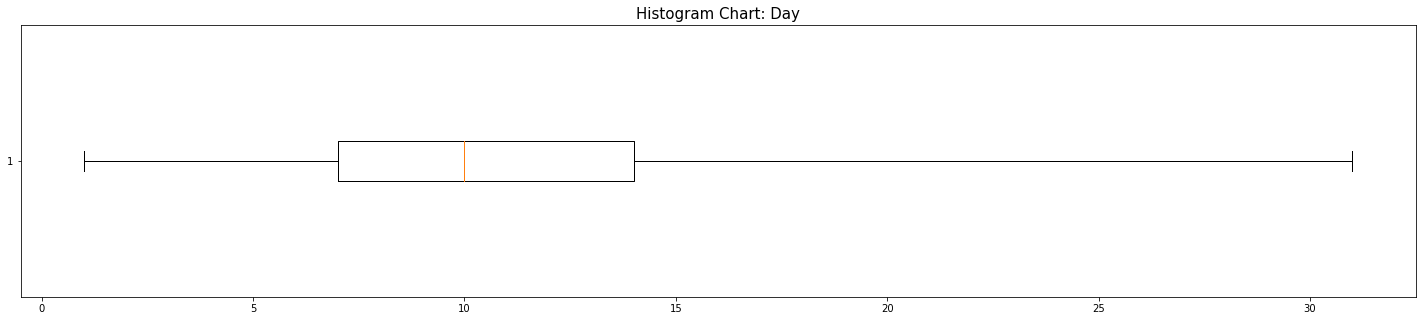

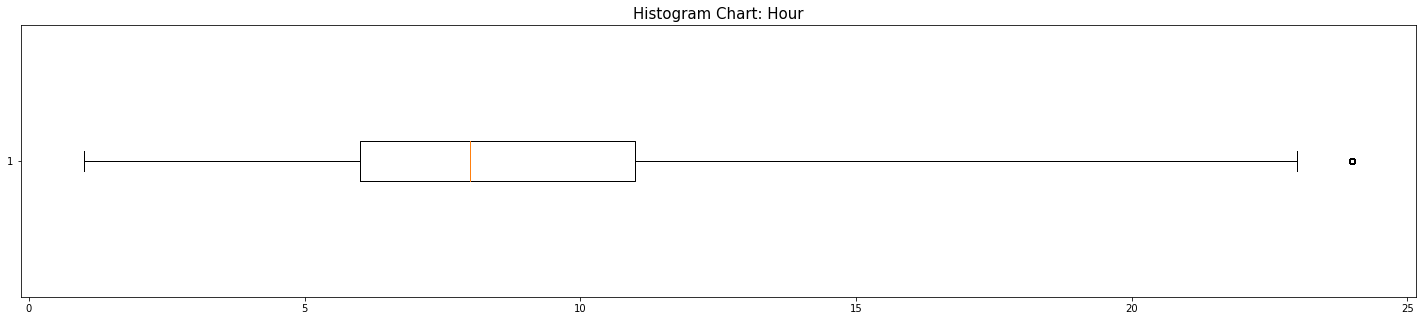

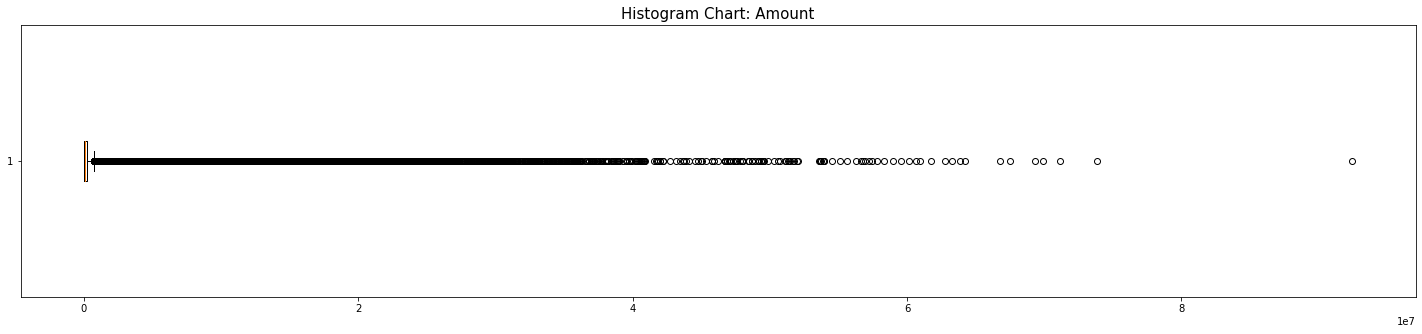

In [132]:
# Box plot por atributo.
def hist_chart(column_name):
    fig, ax = plt.subplots(figsize = (25, 5))
    fig.canvas.set_window_title('Histogram Chart')
    ax.set_title('Histogram Chart: ' + column_name.capitalize(), fontsize = 15)
    ax.boxplot(x = df.loc[:, column_name], vert = False, whis = 2.5, )
    plt.show()

hist_chart('day')
hist_chart('hour')
hist_chart('amount')

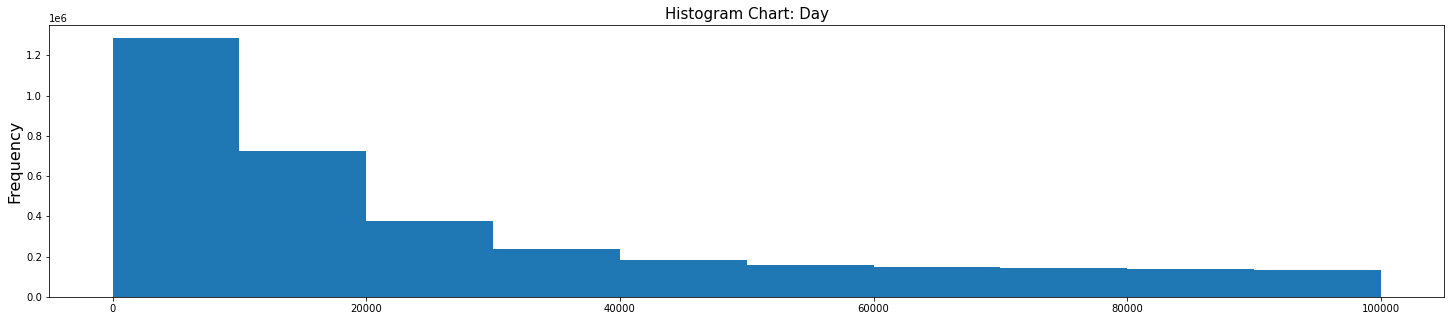

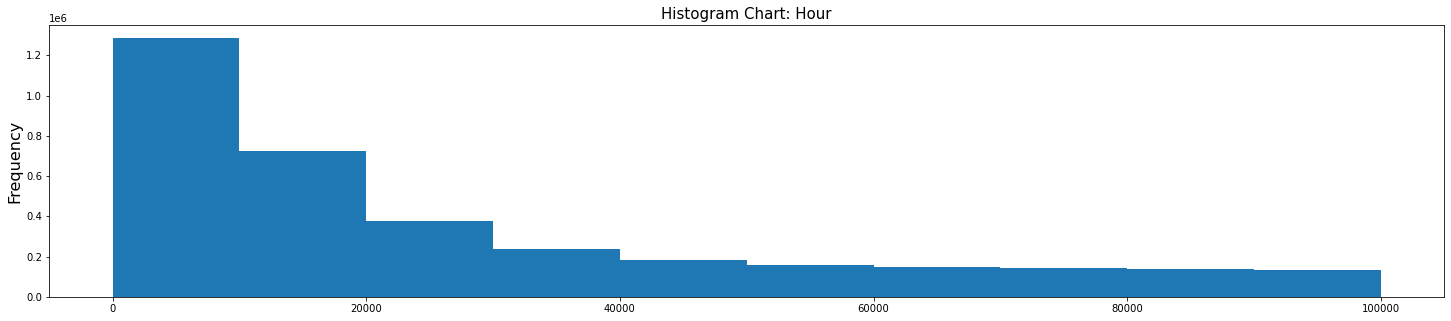

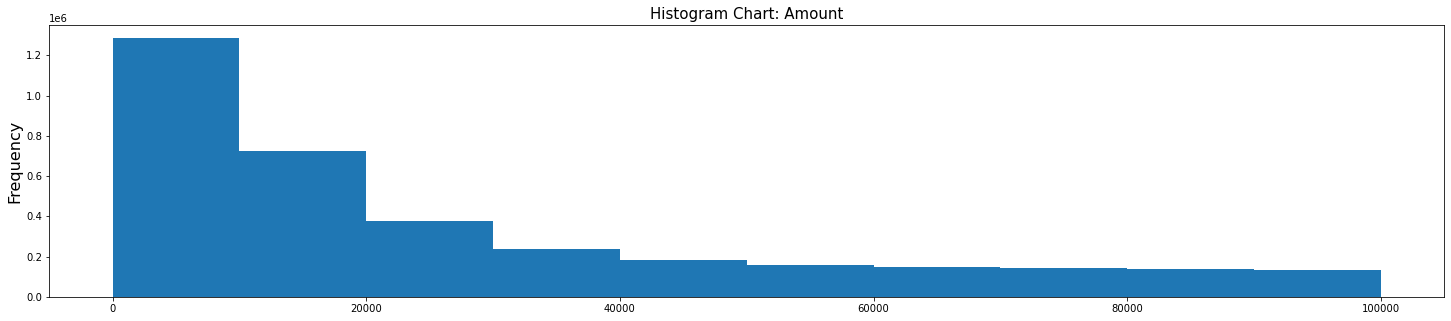

In [138]:
# Box plot por atributo.
def hist_chart(column_name):
    data = df.loc[df.loc[:, 'amount'] <= 100000, 'amount']
    fig, ax = plt.subplots(figsize = (25, 5))
    fig.canvas.set_window_title('Histogram Chart')
    ax.set_title('Histogram Chart: ' + column_name.capitalize(), fontsize = 15)
    ax.set_ylabel('Frequency', fontsize = 16)
    ax.hist(x = data)
    plt.show()

hist_chart('day')
hist_chart('hour')
hist_chart('amount')

In [154]:
# The following function replaces the outliers identified by tukey’s method(values beyond the limits defined above) by NaN:
def tukey(x, k = 2.5):
    x = np.array(x).copy().astype(float)
    first_quartile = np.quantile(x, .25)
    third_quartile = np.quantile(x, .75)
    
    # Define IQR
    iqr = third_quartile - first_quartile
    
    ### Define the allowed limits for 'Normal Data'
    lower_allowed_limit = first_quartile - (k * iqr)
    upper_allowed_limit = third_quartile + (k * iqr)
    
    #set values below the lower limit/above the upper limit as nan
    outliers = (x < lower_allowed_limit) | (x > upper_allowed_limit)
    return outliers

df[tukey(df.amount)]

,day,hour,amount,idOrig,oldbalanceOrig,newbalanceOrig,idDest,oldbalanceDest,newbalanceDest,Cash_in,Cash_out,Debit,Payment,Transfer,isFraud,isFlaggedFraud
85,1,1,1505626.01,85,0.00,0.00,6353390,29031.00,5515763.34,0,0,0,0,1,0,0
88,1,1,761507.39,88,0.00,0.00,6353389,1280036.23,19169204.93,0,0,0,0,1,0,0
89,1,1,1429051.47,89,0.00,0.00,6353389,2041543.62,19169204.93,0,0,0,0,1,0,0
94,1,1,1724887.05,94,0.00,0.00,6353389,3470595.10,19169204.93,0,0,0,0,1,0,0
95,1,1,710544.77,95,0.00,0.00,6353391,738531.50,16518.36,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362613,31,24,1258818.82,6353300,1258818.82,0.00,7447827,503464.50,1762283.33,0,1,0,0,0,1,0
6362616,31,24,6311409.28,6353303,6311409.28,0.00,9073898,0.00,0.00,0,0,0,0,1,1,0
6362617,31,24,6311409.28,6353304,6311409.28,0.00,7430575,68488.84,6379898.11,0,1,0,0,0,1,0
6362618,31,24,850002.52,6353305,850002.52,0.00,9073899,0.00,0.00,0,0,0,0,1,1,0


### 6.3.5. Detección de anomalías utilizando métodos multivariados

In [7]:
# Creación de atributos para medir la diferencia entre los saldos de originantes y destinatarios.
# Justificación: evaluar si la creacion de esta variable y la vinculación con los montos de transacciones permite descubrir patrones ocultos.
df['varOrig'] = df['newbalanceOrig'] - df['oldbalanceOrig']
df['varDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [16]:
# Creacion de dataframe auxiliar.
data = df.loc[:, ['amount', 'varOrig', 'varDest', 'Cash_in', 'Cash_out',
           'Debit', 'Payment', 'Transfer']]

In [10]:
# Importacion de librerias.
from sklearn import covariance
# Define the Elliptic Envelope
el = covariance.EllipticEnvelope(store_precision = True, assume_centered = False, support_fraction = None, contamination = 0.0025, random_state = 42)
# Fit the data - this is where FastMCD is used by sklearn
el.fit(data[0:100000])

EllipticEnvelope(contamination=0.0025, random_state=0)

In [11]:
# Creacion de columna de prediccion de anomalias.
data['anomaly'] = el.predict(data)

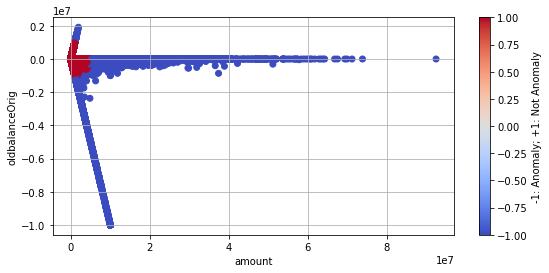

In [12]:
# Create scatterplot and color the anomalies differently
plt.figure(figsize = (9, 4))
ax = plt.scatter(data['amount'], data['varOrig'], c = data['anomaly'], cmap = 'coolwarm')
plt.xlabel('amount')
plt.ylabel('oldbalanceOrig')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')
plt.grid()

Sin determinación del valor de contaminacion.

In [17]:
# Importacion de librerias.
from sklearn import covariance
# Creacion de dataframe auxiliar.
data = df.loc[:, ['amount', 'varOrig', 'varDest', 'Cash_in', 'Cash_out',
           'Debit', 'Payment', 'Transfer']]
# Define the Elliptic Envelope
el = covariance.EllipticEnvelope(store_precision = True, assume_centered = False, support_fraction = None, contamination = 0.0025, random_state = 42)
# Fit the data - this is where FastMCD is used by sklearn
el.fit(data[0:100000])
# Create column that measures Mahalanobis distance
data['Mahalanobis Distance'] = el.mahalanobis(data)

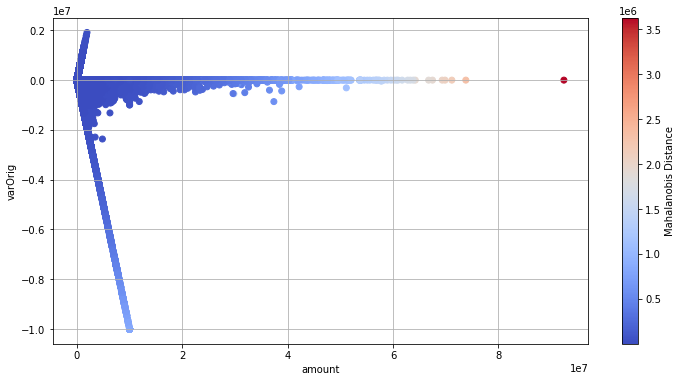

In [18]:
# Create scatterplot and color the anomalies differently
plt.figure(figsize = (12, 6))
ax = plt.scatter(data['amount'],  data['varOrig'], c = data['Mahalanobis Distance'], cmap = 'coolwarm')
#plt.title('Contamination = Does not matter for this method', weight = 'bold')
#ax = sns.scatterplot(d['Var 1'], d['Var 2'], c = d['Anomaly or Not'])
plt.xlabel('amount')
plt.ylabel('varOrig')
plt.colorbar(label = 'Mahalanobis Distance')
plt.grid()